In [1]:
# @title Imports
import math
from itertools import chain

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.distributions as td
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import trange

/home/usrs/pt_shimizu/work/sbsde/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# @title モデルの定義


def timestep_embedding(timesteps, dim, max_period=1000):
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period)
        * torch.arange(start=0, end=half, dtype=torch.float32)
        / half
    ).to(device=timesteps.device)
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding


class FCResNet(nn.Module):
    def __init__(self, data_dim, hidden_dim, num_res_blocks):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.map = nn.Linear(data_dim, hidden_dim)
        self.res_blocks = nn.ModuleList(
            [self.build_res_block() for _ in range(num_res_blocks)]
        )

    def build_linear(self, in_features, out_features):
        linear = nn.Linear(in_features, out_features)
        return linear

    def build_res_block(self):
        hid = self.hidden_dim
        layers = []
        widths = [hid] * 4
        for i in range(len(widths) - 1):
            layers.append(self.build_linear(widths[i], widths[i + 1]))
            layers.append(nn.SiLU())
        return nn.Sequential(*layers)

    def forward(self, x):
        h = self.map(x)
        for res_block in self.res_blocks:
            h = (h + res_block(h)) / np.sqrt(2)
        return h


class ToyModel(torch.nn.Module):
    def __init__(self, data_dim=2, hidden_dim=256, time_embed_dim=128):
        super().__init__()

        self.time_embed_dim = time_embed_dim
        hid = hidden_dim

        self.t_module = nn.Sequential(
            nn.Linear(self.time_embed_dim, hid),
            nn.SiLU(),
            nn.Linear(hid, hid),
        )

        self.x_module = FCResNet(data_dim, hidden_dim, num_res_blocks=3)

        self.out_module = nn.Sequential(
            nn.Linear(hid, hid),
            nn.SiLU(),
            nn.Linear(hid, data_dim),
        )

    def forward(self, t, x):
        t = t.squeeze()
        if t.dim() == 0:
            t = t.repeat(x.shape[0])
        assert t.dim() == 1 and t.shape[0] == x.shape[0]

        t_emb = timestep_embedding(t, self.time_embed_dim)
        t_out = self.t_module(t_emb)
        x_out = self.x_module(x)
        out = self.out_module(x_out + t_out)
        return out

In [3]:
# @title utils
def flatten_dim01(x: torch.Tensor):
    return x.reshape(-1, *x.shape[2:])


def compute_div(os, xs):
    eps = torch.randn_like(xs)
    e_do_dx = torch.autograd.grad(os, xs, eps, create_graph=True, retain_graph=True)[0]
    div = e_do_dx * eps
    return div

In [4]:
# @title 分布の定義


class MixMultiVariateNormal:
    def __init__(self, batch_size, radius=12, num=8, sigmas=None, device="cpu"):
        arc = 2 * np.pi / num
        xs = [np.cos(arc * idx) * radius for idx in range(num)]
        ys = [np.sin(arc * idx) * radius for idx in range(num)]
        mus = [torch.tensor([x, y], device=device) for x, y in zip(xs, ys)]
        dim = len(mus[0])
        sigmas = (
            [torch.eye(dim, device=device) for _ in range(num)]
            if sigmas is None
            else sigmas
        )

        if batch_size % num != 0:
            raise ValueError("batch size must be devided by number of gaussian")
        self.num = num
        self.batch_size = batch_size
        self.dists = []
        for mu, sigma in zip(mus, sigmas):
            dist = td.multivariate_normal.MultivariateNormal(mu, sigma)
            dist._unbroadcasted_scale_tril = dist._unbroadcasted_scale_tril.double()
            self.dists.append(dist)

    def log_prob(self, x):
        # assume equally-weighted
        densities = [torch.exp(dist.log_prob(x.double())) for dist in self.dists]
        return torch.log(sum(densities) / len(self.dists))

    def sample(self, n=None):
        n = self.batch_size if n is None else n
        ind_sample = n / self.num
        samples = [dist.sample([int(ind_sample)]) for dist in self.dists]
        samples = torch.cat(samples, dim=0)
        return samples.float()

    def sample_n(self, n):
        ind_sample = n / self.num
        samples = [dist.sample([int(ind_sample)]) for dist in self.dists]
        samples = torch.cat(samples, dim=0)
        return samples.float()

In [5]:
# @title SDEの定義


class SDE:
    def __init__(self, p_data, p_prior, device, t0=1e-3, T=1, interval=100):
        self.p_data = p_data
        self.p_prior = p_prior
        self.device = device

        self.t0 = t0
        self.T = T
        self.interval = interval
        self.ts = torch.linspace(t0, T, interval, device=device)
        self.dt = T / interval

    def f(self, t, x):
        pass

    def g(self, t):
        pass

    def forward_step(self, t, x, u=None):
        pass

    def backward_step(self, t, x, u=None):
        pass

    def sample_traj(self):
        pass

    def make_train(self):
        pass

    def make_eval(self):
        pass

    def train(self, num_iter):
        self.make_train()
        pbar = trange(num_iter)
        for it in pbar:
            self.opt.zero_grad()
            loss = self.compute_loss()
            loss.backward()
            self.opt.step()
            pbar.set_postfix(loss=loss.item())
            if (it + 1) % 1000 == 0:
                self.sample_plot()

    @torch.no_grad()
    def sample_plot(self, out_path=None, n=2000):
        self.make_eval()
        x_data = self.p_data.sample_n(n).to(self.device)
        x = x_data
        for t in self.ts:
            x = self.forward_step(t, x)
        x_T = x.detach().cpu().numpy()

        x_prior = self.p_prior.sample_n(n).to(self.device)
        x = x_prior
        for t in reversed(self.ts):
            x = self.backward_step(t, x)
        x_0 = x.detach().cpu().numpy()

        x_data = x_data.detach().cpu().numpy()
        x_prior = x_prior.detach().cpu().numpy()

        _, axes = plt.subplots(2, 3, figsize=(16, 10))
        axes[0, 0].plot(x_data[:, 0], x_data[:, 1], "o")
        axes[0, 0].set_title("p_data")
        axes[0, 1].plot(x_T[:, 0], x_T[:, 1], "o")
        axes[0, 1].set_title("p_T")
        axes[0, 2].plot(x_prior[:, 0], x_prior[:, 1], "o")
        axes[0, 2].set_title("p_prior")

        axes[1, 0].plot(x_prior[:, 0], x_prior[:, 1], "o")
        axes[1, 0].set_title("p_prior")
        axes[1, 1].plot(x_0[:, 0], x_0[:, 1], "o")
        axes[1, 1].set_title("p_0")
        axes[1, 2].plot(x_data[:, 0], x_data[:, 1], "o")
        axes[1, 2].set_title("p_data")
        for i in range(2):
            for j in range(3):
                axes[i, j].set_xlim(-20, 20)
                axes[i, j].set_ylim(-20, 20)
        if out_path is not None:
            plt.savefig(out_path)
        plt.show()

In [6]:
# @title common

batch_size = 80
num_iter = 10000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

p_data = MixMultiVariateNormal(batch_size, radius=12, num=8, device=device)
p_prior = MixMultiVariateNormal(batch_size, radius=6, num=2, device=device)

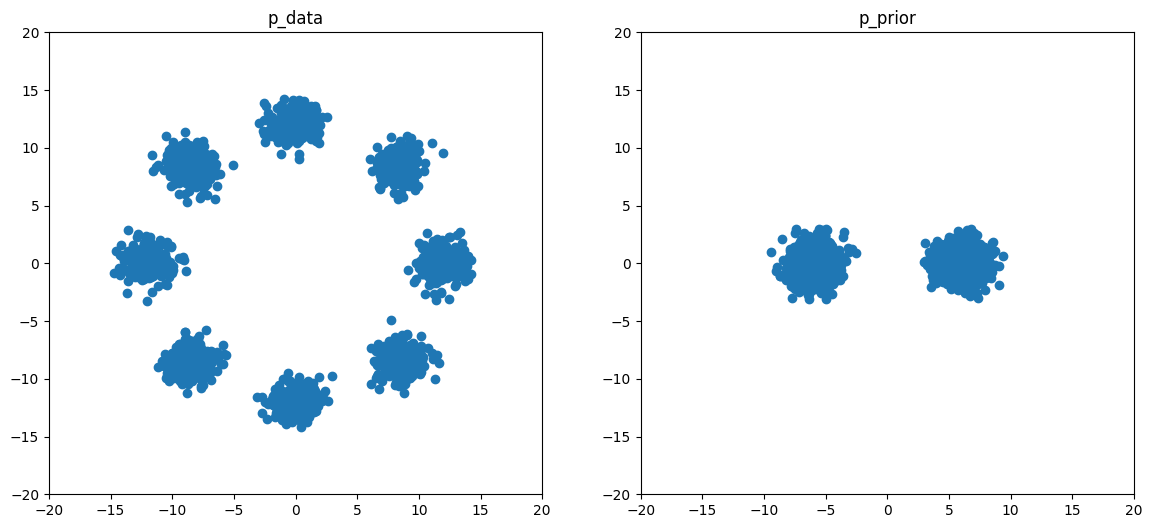

In [7]:
x_data = p_data.sample(2000).cpu().numpy()
x_prior = p_prior.sample(2000).cpu().numpy()

_, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].plot(x_data[:, 0], x_data[:, 1], "o")
axes[0].set_title("p_data")
axes[1].plot(x_prior[:, 0], x_prior[:, 1], "o")
axes[1].set_title("p_prior")
for i in range(2):
    axes[i].set_xlim(-20, 20)
    axes[i].set_ylim(-20, 20)
plt.show()
plt.close()

### 清水の導出で出た式 - SU

簡略化して，$f(t, X_t) = 0, g(t) = 1.0$とする．

- Forward
$$
d X_t = u_\phi(t, X_t) dt + d W_t, \quad X_0 \sim \mu
$$

- Backward
$$
d X_t = \Big[u_\phi(t, X_t) - s_\theta(t, X_t)\Big] dt + d W_t, \quad X_T \sim \pi
$$

Loss

$$
\min_{\phi, \theta} \, - \mathbb{E}_{p_T}[\log \pi(X_T)] + \int_{0}^{T} dt \; \mathbb{E}_{p_t}\bigg[ \frac{1}{2} ||s_\theta(t, X_t)||^2 + \nabla \cdot \big[s_\theta(t, X_t) - u_\phi(t, X_t)\big] \bigg]
$$


In [8]:
# @title


class US(SDE):
    def __init__(self, p_data, p_prior, device, t0=1e-3, T=1, interval=100):
        super().__init__(p_data, p_prior, device, t0, T, interval)

        self.net_u = ToyModel().to(device)
        self.net_s = ToyModel().to(device)
        self.opt = optim.AdamW(
            chain(self.net_u.parameters(), self.net_s.parameters()), lr=1e-4
        )

    def f(self, t, x):
        return torch.zeros_like(x)

    def g(self, t):
        return torch.full_like(t, fill_value=self.epsilon)

    def forward_step(self, t, x, u=None):
        if u is None:
            u = self.net_u(t, x)
        dX = u * self.dt + torch.randn_like(x) * np.sqrt(self.dt)
        return x + dX

    def backward_step(self, t, x):
        u = self.net_u(t, x)
        s = self.net_s(t, x)
        dX = (u - s) * self.dt + torch.randn_like(x) * np.sqrt(self.dt)
        return x - dX

    def train(self, num_iter):
        self.make_train()
        pbar = trange(num_iter)
        for it in pbar:
            self.opt.zero_grad()
            loss = self.compute_loss()
            loss.backward()
            nn.utils.clip_grad_norm_(
                chain(self.net_u.parameters(), self.net_s.parameters()), 1.0
            )
            self.opt.step()
            pbar.set_postfix(loss=loss.item())
            if (it + 1) % 1000 == 0:
                self.sample_plot()

    def sample_traj(self):
        x = self.p_data.sample().to(self.device)
        xs = torch.zeros(x.shape[0], len(self.ts), x.shape[1], device=self.device)
        us = torch.zeros_like(xs)

        for i, t in enumerate(self.ts):
            u = self.net_u(t, x)
            x = self.forward_step(t, x, u=u)
            xs[:, i] = x
            us[:, i] = u
        x_term = x
        return xs, us, x_term

    def compute_loss(self):
        x, u, x_term = self.sample_traj()
        t = self.ts.repeat(batch_size)
        x = flatten_dim01(x)
        u = self.net_u(t, x)
        s = self.net_s(t, x)

        integrand = 0.5 * s**2 + compute_div(s - u, x)
        grads_u = torch.autograd.grad(
            outputs=u, inputs=x, grad_outputs=torch.ones_like(u), create_graph=True
        )[0]
        grad_penalty_u = grads_u.norm(2, dim=1).mean()
        E_integrand = integrand.reshape(
            x_term.shape[0], self.interval, x_term.shape[-1]
        ).mean(dim=0)
        loss = (
            -self.p_prior.log_prob(x_term).mean()
            + (E_integrand * self.dt).sum()
            + grad_penalty_u
        )
        return loss

    def make_train(self):
        self.net_u.train()
        self.net_s.train()

    def make_eval(self):
        self.net_u.eval()
        self.net_s.eval()


def train_and_plot_us(num_iter):
    us = US(p_data, p_prior, device)
    try:
        us.train(num_iter)
    except:
        print("Error occured in training")

In [9]:
train_and_plot_us(num_iter)

  1%|          | 119/10000 [00:26<36:30,  4.51it/s, loss=8.03]